### dependencies

In [1]:
import os, random
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from keras import backend as k_backend
import tensorflow_addons as tfa

C:\Users\Ridwan Faturrahman\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### files function

In [2]:
def list_files(full_data_path, image_ext):
    masked_files = []
    unmasked_files = []
    
    for r, d, f in os.walk(full_data_path):
        for file in f:
            if file.endswith(".txt"):  
                
                # first, let's check if there is only one object
                with open(full_data_path + "/" + file, 'r') as fp: 
                    lines = fp.readlines()
                
                file_name = file[0:len(file) - len(".txt")]  
                # secondly, check if the paired image actually exist
                image_path = full_data_path + "/" + file_name + image_ext
                
                if os.path.isfile(image_path):
                    # checking the class. '0' means masked, '1' for unmasked
                    if lines[0][0] == '0':
                        masked_files.append(file_name)
                    else:
                        unmasked_files.append(file_name)
    return masked_files, unmasked_files

In [3]:
def get_box_coordinate(full_data_path, file_name):
    lines = []
    with open(full_data_path + "/" + file_name + ".txt", 'r') as fp: 
        lines = fp.readlines()
    if (len(lines) >= 1):
        return np.array(lines[0][1:].split(), dtype=float)
    else:
        return []

In [4]:
def split_files(files, split_percentage):
    size = len(files)
    
    split_training = int(split_percentage[0] * size / 100)
    split_validation = split_training + int(split_percentage[1] * size / 100)
    
    return files[0:split_training], files[split_training:split_validation], files[split_validation:]

def split_data(masked_files, unmasked_files, split_percentage = [70, 20]):
    random.shuffle(masked_files)
    random.shuffle(unmasked_files)
    
    training_masked_files, validation_masked_files, test_masked_files = split_files(masked_files, split_percentage)
    training_unmasked_files, validation_unmasked_files, test_unmasked_files = split_files(unmasked_files, split_percentage)
    
    training = training_masked_files + training_unmasked_files
    validation = validation_masked_files + validation_unmasked_files
    test = test_masked_files + test_unmasked_files
    
    random.shuffle(training)
    random.shuffle(validation)
    random.shuffle(test)
    
    return training, validation, test

In [36]:
def format_image(img, box, input_size):
    height, width = img.shape 
    max_size = max(height, width)
    r = max_size / input_size
    new_width = int(width / r)
    new_height = int(height / r)
    new_size = (new_width, new_height)
    resized = cv.resize(img, new_size, interpolation= cv.INTER_LINEAR)
    new_image = np.zeros((input_size, input_size), dtype=np.uint8)
    new_image[0:new_height, 0:new_width] = resized

    x, y, w, h = box[0], box[1], box[2], box[3]
    new_box = [int((x - 0.5*w)* width / r), int((y - 0.5*h) * height / r), int(w*width / r), int(h*height / r)]

    return new_image, new_box

def show_image_with_box(full_data_path, file_name, image_ext, input_size):
    temp_img = cv.imread(full_data_path + "/" + file_name + image_ext, cv.IMREAD_GRAYSCALE)
    temp_box = get_box_coordinate(full_data_path, file_name)
    temp_img_formated, box = format_image(temp_img, temp_box, input_size)
    temp_color_img = cv.cvtColor(temp_img_formated, cv.COLOR_GRAY2RGB)
    cv.rectangle(temp_color_img, box, (0, 255, 0), 2)
    plt.imshow(temp_color_img)
    plt.axis("off")
    plt.show()

### dataset function

In [6]:
def data_load(files, full_data_path, image_ext, input_size):
    X = []
    Y = []
    
    for file in files:
        img = cv.imread(os.path.join(full_data_path, file + image_ext), cv.IMREAD_GRAYSCALE)
        
        # 1: unmasked, 0: masked
        k = 1

        with open(full_data_path + "/" + file + ".txt", 'r') as fp: 
            line = fp.readlines()[0]
            if line[0] == '0':
                k = 0
        
            box = np.array(line[1:].split(), dtype=float)
        
        img, box = format_image(img, box, input_size)
        img = img.astype(float) / 255.
        
        box = np.asarray(box, dtype=float) / input_size
        label = np.append(box, k)
        
        X.append(img)
        Y.append(label)
        
    X = np.array(X)
    X = np.expand_dims(X, axis=3)
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    Y = tf.convert_to_tensor(Y, dtype=tf.float32)

    result = tf.data.Dataset.from_tensor_slices((X, Y))
    return result    

In [7]:
def format_instance(image, label):
    return image, (tf.one_hot(int(label[4]), CLASSES), [label[0], label[1], label[2], label[3]])

In [8]:
def tune_training_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
#     dataset = dataset.repeat() # The dataset be repeated indefinitely.
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [9]:
def tune_validation_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(len(validation_files) // 4)
#     dataset = dataset.repeat()
    return dataset

In [10]:
def tune_test_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(1) 
    dataset = dataset.repeat()
    return dataset

In [11]:
def show_dataset(dataset, input_size):
    plt.figure(figsize=(20, 10))
    for images, labels in dataset.take(1):
        for i in range(BATCH_SIZE):
            ax = plt.subplot(4, BATCH_SIZE//4, i + 1)
            label = labels[0][i]
            box = (labels[1][i] * input_size)
            box = tf.cast(box, tf.int32)

            image = images[i].numpy().astype("float") * 255.0
            image = image.astype(np.uint8)
            image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

            color = (0, 0, 255)
            if label[0] > 0:
                color = (0, 255, 0)

            cv.rectangle(image_color, box.numpy(), color, 2)

            plt.imshow(image_color)
            plt.axis("off")            

In [12]:
def show_predict_and_target(dataset, input_size):
    plt.figure(figsize=(20, 10))
    dataset_list = list(dataset.take(20).as_numpy_iterator())
    
    # debug
    # print(len(dataset_list))
    
    for i in range(len(dataset_list)):
        ax = plt.subplot(4, 10, i + 1)
        image, labels = dataset_list[i]

        predictions = model(image)

        # debug
        # print(predictions)
        
        predicted_box = predictions[1][0] * input_size
        predicted_box = tf.cast(predicted_box, tf.int32)

        predicted_label = predictions[0][0]

        image = image[0]

        actual_label = labels[0][0]
        actual_box = labels[1][0] * input_size
        actual_box = tf.cast(actual_box, tf.int32)

        image = image.astype("float") * 255.0
        image = image.astype(np.uint8)
        image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

        color = (255, 0, 0)
        # print box red if predicted and actual label do not match
        if (predicted_label[0] > 0.5 and actual_label[0] > 0) or (predicted_label[0] < 0.5 and actual_label[0] == 0):
            color = (0, 255, 0)

        cv.rectangle(image_color, predicted_box.numpy(), color, 2)
        cv.rectangle(image_color, actual_box.numpy(), (0, 0, 255), 2)

        IoU = intersection_over_union(predicted_box.numpy(), actual_box.numpy())

        plt.title("IoU:" + format(IoU, '.4f'))
        plt.imshow(image_color)
        plt.axis("off")

In [13]:
def show_history_learning(history):
    # Accuracy
    plt.plot(history.history['classifier_head_accuracy'])
    plt.plot(history.history['val_classifier_head_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # Classification Loss
    plt.plot(history.history['classifier_head_loss'])
    plt.plot(history.history['val_classifier_head_loss'])
    plt.title('Classification Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # Bounding Box Loss
    plt.plot(history.history['regressor_head_loss'])
    plt.plot(history.history['val_regressor_head_loss'])
    plt.title('Bounding Box Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

### model function

In [14]:
def build_feature_extractor(inputs):

    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(input_size, input_size, 1))(inputs)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    return x

def build_model_adaptor(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    return x

def build_classifier_head(inputs):
    return tf.keras.layers.Dense(CLASSES, activation='softmax', name = 'classifier_head')(inputs)

def build_regressor_head(inputs):
    return tf.keras.layers.Dense(units = '4', name = 'regressor_head')(inputs)

def build_model(inputs):
    
    feature_extractor = build_feature_extractor(inputs)

    model_adaptor = build_model_adaptor(feature_extractor)

    classification_head = build_classifier_head(model_adaptor)

    regressor_head = build_regressor_head(model_adaptor)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_head, regressor_head])

    model.compile(optimizer=tf.keras.optimizers.Adam(), 
          loss = {'classifier_head' : 'categorical_crossentropy', 'regressor_head' : 'mse' }, 
          metrics = {'classifier_head' : 'accuracy', 'regressor_head' : 'mse' })
#     model.compile(optimizer=tf.keras.optimizers.Adam(), 
#               loss = {'classifier_head' : 'categorical_crossentropy', 'regressor_head' : 'mse' }, 
#               metrics = {'classifier_head' : 'accuracy', 'regressor_head' : 'mse' })

    return model

In [15]:
def intersection_over_union(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] + 1) * (boxA[3] + 1)
    boxBArea = (boxB[2] + 1) * (boxB[3] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

In [16]:
# Loss function IoU (Jaccard Index)
def iou_loss(y_true, y_pred):
    iou = intersection_over_union(y_true, y_pred)
    return 1 - iou  # Inverse IoU

In [17]:
def mean_squared_error(y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    return k_backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)   

### execution

In [18]:
## Global variable
# Dataset
CLASSES = 2
BATCH_SIZE = 1

In [19]:
full_data_path = "datasets-minimum"
image_ext = '.jpg'
input_size = 244

# split training-validation-test : 70-20-10
split_percentage = [70, 20]

masked_files, unmasked_files = list_files(full_data_path, image_ext)
training_files, validation_files, test_files = split_data(masked_files, unmasked_files, split_percentage)

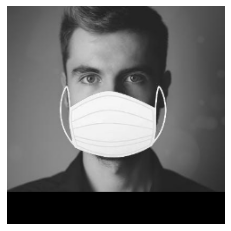

In [37]:
# debug
# for image in training_files:
#     show_image_with_box(full_data_path, image, image_ext, input_size)
# for image in validation_files:
#     show_image_with_box(full_data_path, image, image_ext, input_size)
# for image in test_files:
#     show_image_with_box(full_data_path, image, image_ext, input_size)
show_image_with_box(full_data_path, training_files[1], image_ext, input_size)

In [21]:
raw_train_ds = data_load(training_files, full_data_path, image_ext, input_size)
raw_validation_ds = data_load(validation_files, full_data_path, image_ext, input_size)
raw_test_ds = data_load(test_files, full_data_path, image_ext, input_size)

In [22]:
train_ds = tune_training_ds(raw_train_ds)
validation_ds = tune_validation_ds(raw_validation_ds)
test_ds = tune_test_ds(raw_test_ds)

In [33]:
# debug
# show_dataset(train_ds, input_size)

In [24]:
## Global variable
# build Model
DROPOUT_FACTOR = 0.5

In [25]:
model = build_model(tf.keras.layers.Input(shape=(input_size, input_size, 1,)))

In [26]:
# debug
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 244, 244, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 242, 242, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 average_pooling2d (AveragePool  (None, 121, 121, 16  0          ['conv2d[0][0]']                 
 ing2D)                         )                                                             

In [27]:
# history = model.fit(train_ds,
#                     steps_per_epoch=(len(training_files) // BATCH_SIZE),
#                     validation_data=validation_ds, validation_steps=1, 
#                     epochs=EPOCHS,
#                     verbose=1)

In [28]:
# debug
# show_history_learning(history)

In [29]:
## Global variable
# Model.fit
EPOCHS = 100

In [30]:
model.fit(train_ds,
#                     steps_per_epoch=(len(training_files) // BATCH_SIZE),
                    validation_data=validation_ds, 
#                     validation_steps=1, 
                    epochs=EPOCHS,
                    verbose=1)

Epoch 1/100
14/14 [==============================] - 3s 109ms/step - loss: 0.8938 - classifier_head_loss: 0.7817 - regressor_head_loss: 0.1121 - classifier_head_accuracy: 0.4286 - regressor_head_mse: 0.1121 - val_loss: 0.7264 - val_classifier_head_loss: 0.6893 - val_regressor_head_loss: 0.0371 - val_classifier_head_accuracy: 0.7500 - val_regressor_head_mse: 0.0371
Epoch 2/100
14/14 [==============================] - 1s 66ms/step - loss: 0.7180 - classifier_head_loss: 0.6768 - regressor_head_loss: 0.0413 - classifier_head_accuracy: 0.5714 - regressor_head_mse: 0.0413 - val_loss: 0.7797 - val_classifier_head_loss: 0.6916 - val_regressor_head_loss: 0.0881 - val_classifier_head_accuracy: 0.2500 - val_regressor_head_mse: 0.0881
Epoch 3/100
14/14 [==============================] - 1s 68ms/step - loss: 0.6801 - classifier_head_loss: 0.6393 - regressor_head_loss: 0.0409 - classifier_head_accuracy: 0.7857 - regressor_head_mse: 0.0409 - val_loss: 0.7554 - val_classifier_head_loss: 0.6881 - val_r

14/14 [==============================] - 1s 79ms/step - loss: 0.0257 - classifier_head_loss: 0.0055 - regressor_head_loss: 0.0202 - classifier_head_accuracy: 1.0000 - regressor_head_mse: 0.0202 - val_loss: 2.3498 - val_classifier_head_loss: 2.3116 - val_regressor_head_loss: 0.0382 - val_classifier_head_accuracy: 0.7500 - val_regressor_head_mse: 0.0382
Epoch 24/100
14/14 [==============================] - 1s 80ms/step - loss: 0.0196 - classifier_head_loss: 0.0047 - regressor_head_loss: 0.0149 - classifier_head_accuracy: 1.0000 - regressor_head_mse: 0.0149 - val_loss: 2.2538 - val_classifier_head_loss: 2.2165 - val_regressor_head_loss: 0.0373 - val_classifier_head_accuracy: 0.7500 - val_regressor_head_mse: 0.0373
Epoch 25/100
14/14 [==============================] - 1s 68ms/step - loss: 0.0340 - classifier_head_loss: 0.0059 - regressor_head_loss: 0.0282 - classifier_head_accuracy: 1.0000 - regressor_head_mse: 0.0282 - val_loss: 2.2320 - val_classifier_head_loss: 2.0657 - val_regressor_he

14/14 [==============================] - 1s 67ms/step - loss: 0.0102 - classifier_head_loss: 0.0017 - regressor_head_loss: 0.0085 - classifier_head_accuracy: 1.0000 - regressor_head_mse: 0.0085 - val_loss: 2.3803 - val_classifier_head_loss: 2.3441 - val_regressor_head_loss: 0.0362 - val_classifier_head_accuracy: 0.7500 - val_regressor_head_mse: 0.0362
Epoch 46/100
14/14 [==============================] - 1s 65ms/step - loss: 0.0083 - classifier_head_loss: 0.0014 - regressor_head_loss: 0.0069 - classifier_head_accuracy: 1.0000 - regressor_head_mse: 0.0069 - val_loss: 2.3424 - val_classifier_head_loss: 2.3056 - val_regressor_head_loss: 0.0367 - val_classifier_head_accuracy: 0.7500 - val_regressor_head_mse: 0.0367
Epoch 47/100
14/14 [==============================] - 1s 66ms/step - loss: 0.0055 - classifier_head_loss: 0.0015 - regressor_head_loss: 0.0040 - classifier_head_accuracy: 1.0000 - regressor_head_mse: 0.0040 - val_loss: 2.4676 - val_classifier_head_loss: 2.4321 - val_regressor_he

14/14 [==============================] - 1s 59ms/step - loss: 0.0043 - classifier_head_loss: 5.5779e-04 - regressor_head_loss: 0.0038 - classifier_head_accuracy: 1.0000 - regressor_head_mse: 0.0038 - val_loss: 2.4732 - val_classifier_head_loss: 2.4328 - val_regressor_head_loss: 0.0404 - val_classifier_head_accuracy: 0.7500 - val_regressor_head_mse: 0.0404
Epoch 68/100
14/14 [==============================] - 1s 64ms/step - loss: 0.0052 - classifier_head_loss: 7.7172e-04 - regressor_head_loss: 0.0044 - classifier_head_accuracy: 1.0000 - regressor_head_mse: 0.0044 - val_loss: 2.3959 - val_classifier_head_loss: 2.3598 - val_regressor_head_loss: 0.0361 - val_classifier_head_accuracy: 0.7500 - val_regressor_head_mse: 0.0361
Epoch 69/100
14/14 [==============================] - 1s 69ms/step - loss: 0.0045 - classifier_head_loss: 6.5216e-04 - regressor_head_loss: 0.0039 - classifier_head_accuracy: 1.0000 - regressor_head_mse: 0.0039 - val_loss: 2.4735 - val_classifier_head_loss: 2.4232 - val_

14/14 [==============================] - 1s 78ms/step - loss: 0.0035 - classifier_head_loss: 4.9241e-04 - regressor_head_loss: 0.0030 - classifier_head_accuracy: 1.0000 - regressor_head_mse: 0.0030 - val_loss: 2.4002 - val_classifier_head_loss: 2.3645 - val_regressor_head_loss: 0.0357 - val_classifier_head_accuracy: 0.7500 - val_regressor_head_mse: 0.0357
Epoch 90/100
14/14 [==============================] - 1s 79ms/step - loss: 0.0038 - classifier_head_loss: 4.3958e-04 - regressor_head_loss: 0.0033 - classifier_head_accuracy: 1.0000 - regressor_head_mse: 0.0033 - val_loss: 2.4763 - val_classifier_head_loss: 2.4374 - val_regressor_head_loss: 0.0389 - val_classifier_head_accuracy: 0.7500 - val_regressor_head_mse: 0.0389
Epoch 91/100
14/14 [==============================] - 1s 70ms/step - loss: 0.0037 - classifier_head_loss: 4.8707e-04 - regressor_head_loss: 0.0032 - classifier_head_accuracy: 1.0000 - regressor_head_mse: 0.0032 - val_loss: 2.3925 - val_classifier_head_loss: 2.3580 - val_

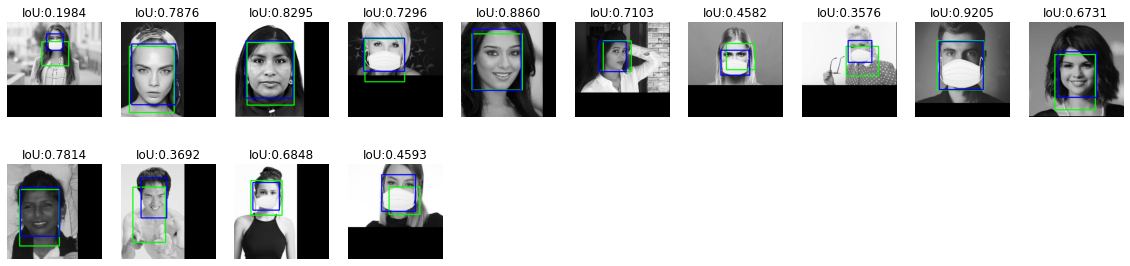

In [31]:
# debug
show_predict_and_target(train_ds, input_size)

In [206]:
# tfa.losses.GIoULoss()